In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import gym
import torch

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [2]:
from tictactoe import TicTacToe
from plot import plot_test_game, plot_reward
from game import get_hashes_map, check_strategy
from strategy import GreedyStrategy, RandomStrategy, LazyGreedyStrategy, DQNStrategy, MCTSStrategy
from qlearning import q_learning
from wrapper import DQNWrapper
from dqn import DenseNetwork, DQN
from mcts import MCTree, train_mcts

# 1 этап. Q-обучение и 3х3

## Доска 3х3

*Скажи мне, кто твой учитель, и я скажу тебе...*

- Играем в крестики-нолики на доске 3х3
- Обучаем каждую стратегию отдельно
- Сравниваем стратегии попарно и отдельно

In [3]:
N_ITER = 100000

In [4]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n = env.n_rows * env.n_cols
hashes_map_x, hashes_map_o = get_hashes_map(env.n_rows, env.n_cols)
print(f"Число состояний для х и о соответсственно: {len(hashes_map_x), len(hashes_map_o)}")

Число состояний для х и о соответсственно: (3139, 2781)


**крестики обучаются против случайной стратегии**

100%|██████████| 100000/100000 [01:12<00:00, 1386.73it/s]


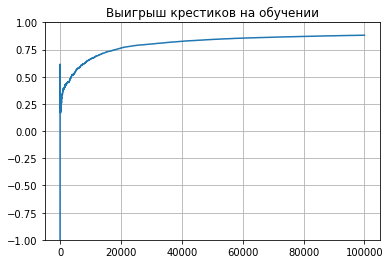

In [5]:
pi_x = GreedyStrategy(hashes_map_x)
avg_reward_x = q_learning(env, pi_x, play_as_crosses=True, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш крестиков на обучении")

**нолики обучаются против случайной стратегии**

100%|██████████| 100000/100000 [01:11<00:00, 1398.32it/s]


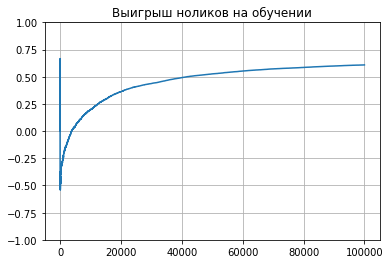

In [6]:
pi_o = GreedyStrategy(hashes_map_o)
avg_reward_o = q_learning(env, pi_o, play_as_crosses=False, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_o, title="Выигрыш ноликов на обучении")

*Игра обученных стратегий*

In [7]:
_ = check_strategy(env, pi_x, pi_o, random_crosses=False, random_naughts=False, num_experiments=1000)

Доля выигрышей крестиков: 1.000
Доля выигрышей ноликов: 0.000


А что если учить играть против хороших стратегий, а не случайных?

**нолики обучаются против обученной стратегии**

100%|██████████| 100000/100000 [01:11<00:00, 1398.61it/s]


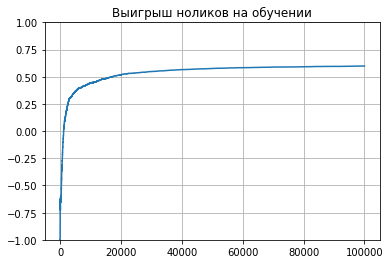

In [8]:
pi_o = GreedyStrategy(hashes_map_o)
avg_reward_o2 = q_learning(env, pi_o, play_as_crosses=False, opponent=pi_x, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_o2, title="Выигрыш ноликов на обучении")

In [9]:
_ = check_strategy(env, None, pi_o, random_crosses=True, random_naughts=False, num_experiments=1000)

Доля выигрышей крестиков: 0.459
Доля выигрышей ноликов: 0.324


In [10]:
_ = check_strategy(env, pi_x, pi_o, random_crosses=False, random_naughts=False, num_experiments=1000)

Доля выигрышей крестиков: 0.000
Доля выигрышей ноликов: 1.000


*Обученная стратегия ноликов лучше по всем фронтам (и со случайным, и с обученным оппонентом)*

do we need to go deeper?

**крестики обучаются против обученной стратегии**

100%|██████████| 100000/100000 [00:57<00:00, 1746.72it/s]


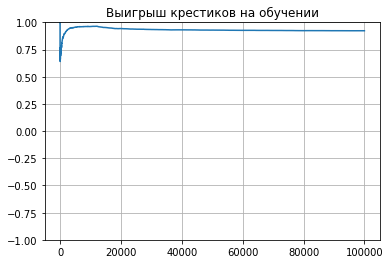

In [11]:
pi_x2 = GreedyStrategy(hashes_map_x)
avg_reward_x = q_learning(env, pi_x2, play_as_crosses=True, opponent=pi_o, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш крестиков на обучении")

In [12]:
_ = check_strategy(env, pi_x, pi_o, random_crosses=False, random_naughts=False, num_experiments=1000)

Доля выигрышей крестиков: 0.000
Доля выигрышей ноликов: 1.000


*Очевидно, что*
- *стратегия крестиков, научившаяся играть против*
- *стратегии ноликов, научившейся играть против*
- *стратегии крестиков, научившейся играть против*
- *случайной стратегии... в общем случае, хороша*

# 2 этап. DQN, MCST и все все все

## 2.1 Доска 5х5 и Q-learning

А что если взять крестики нолики 5х5?

**Здесь идем на хитрость:**

*не создаем пространство всех возможных состояний, а добавляем их в таблицу Q при встрече. В редковстречающихся состояних просто играем случайно. Это экономит время и память и не ухудшает качество*

In [13]:
N_ITER = 10000
# N_ITER = 100000

In [3]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=5)

**крестики обучаются против случайной стратегии**

100%|██████████| 10000/10000 [00:34<00:00, 293.59it/s]


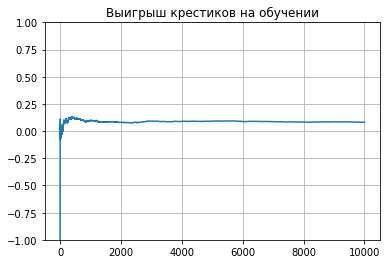

In [15]:
pi_x = LazyGreedyStrategy(env.n_cols)
avg_reward_x = q_learning(env, pi_x, play_as_crosses=True, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш крестиков на обучении")

**нолики обучаются против случайной стратегии**

100%|██████████| 10000/10000 [00:32<00:00, 305.71it/s]


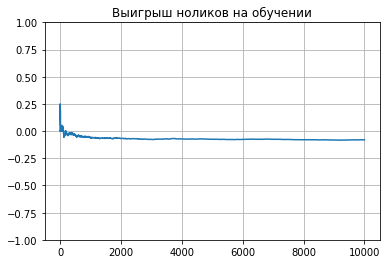

In [16]:
pi_o = LazyGreedyStrategy(env.n_cols)
avg_reward_o = q_learning(env, pi_o, play_as_crosses=False, eps=0.1, alpha=0.8, gamma=0.99, num_experiments=N_ITER)
plot_reward(avg_reward_o, title="Выигрыш ноликов на обучении")

К сожалению, на 5х5 Q-learning против случайных стратегий не обучается совершенно. 

Другое дело более продвинутые DQN, MCST - их и будем сравнивать в самом конце

## 2.2 Нейросети

Теперь возьмем Dueling DQN. 

Как ни странно но DQN с 2 полносвязными слоями и совсем без сверточных слоев хорошо себя показывает на средних размеров досках. Будем использовать имеено такую архитектуру (для скорости обучения)

### Dueling QDN

In [4]:
N_ITER = 10000
# N_ITER = 100000

In [5]:
# device = torch.device("cpu")
device = torch.device("cuda")

**крестики обучаются против случайной стратегии**

100%|██████████| 10000/10000 [04:29<00:00, 37.14it/s]


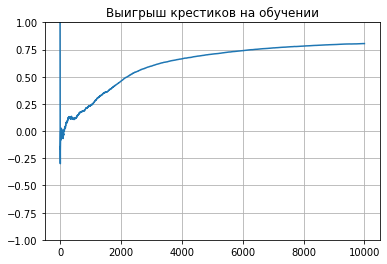

In [6]:
wrapper = DQNWrapper(env, play_as_crosses=True, opponent=RandomStrategy())
dqn = DQN(wrapper, gamma=0.8, eps_decay=10000, model_kind="dueling_dense", device=device)
avg_reward_x = dqn.fit(num_experiments=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш крестиков на обучении")

In [7]:
pi_x1 = DQNStrategy(dqn, env.n_cols)
_ = check_strategy(env, pi_x1, None, random_crosses=False, random_naughts=True, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.925
Доля выигрышей ноликов: 0.015


**нолики обучаются против случайной стратегии**

100%|██████████| 10000/10000 [04:49<00:00, 34.57it/s]


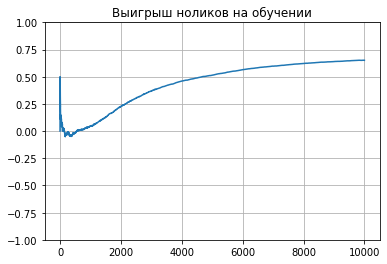

In [8]:
wrapper = DQNWrapper(env, play_as_crosses=False, opponent=RandomStrategy())
dqn = DQN(wrapper, gamma=0.8, eps_decay=10000, model_kind="dueling_dense", device=device)
avg_reward_x = dqn.fit(num_experiments=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш ноликов на обучении")

In [9]:
pi_o1 = DQNStrategy(dqn, env.n_cols)
_ = check_strategy(env, None, pi_o1, random_crosses=True, random_naughts=False, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.066
Доля выигрышей ноликов: 0.843


**Игра обученных стратегий**

In [10]:
_ = check_strategy(env, pi_x1, pi_o1, random_crosses=False, random_naughts=False, num_experiments=N_ITER)

Доля выигрышей крестиков: 1.000
Доля выигрышей ноликов: 0.000


## 2.3 Деревья

### Monte Carlo tree search

In [11]:
# N_ITER = 10000
N_ITER = 100000

**крестики обучаются против случайной стратегии**

100%|██████████| 100000/100000 [04:19<00:00, 385.93it/s]


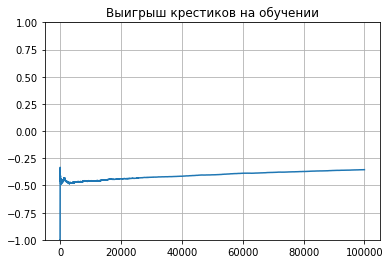

In [12]:
mctree = MCTree()
avg_reward_x = train_mcts(env, mctree, play_as_crosses=True, n_iters=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш крестиков на обучении")

In [13]:
pi_x2 = MCTSStrategy(mctree)
_ = check_strategy(env, pi_x2, None, random_crosses=False, random_naughts=True, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.358
Доля выигрышей ноликов: 0.153


**нолики обучаются против случайной стратегии**

100%|██████████| 100000/100000 [04:16<00:00, 389.74it/s]


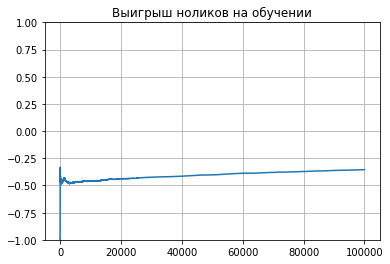

In [14]:
mctree = MCTree()
avg_reward_o = train_mcts(env, mctree, play_as_crosses=False, n_iters=N_ITER)
plot_reward(avg_reward_x, title="Выигрыш ноликов на обучении")

In [15]:
pi_o2 = MCTSStrategy(mctree)
_ = check_strategy(env, None, pi_o2, random_crosses=True, random_naughts=False, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.246
Доля выигрышей ноликов: 0.195


*Стратегии по MCST долго обучаются на 5х5. Это может быть связано с тем, что на этапе обновления оценки узлов по Монте Карло разыгрывается только один rollout со случайной стратегией. Обучение можно качественно улучшить, если оценивать по нескольким rollout'ам и вместо случайно стратегии брать булее сложную (например эвристическую)*

**Игра обученных стратегий**

In [16]:
_ = check_strategy(env, pi_x2, pi_o2, random_crosses=False, random_naughts=False, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.142
Доля выигрышей ноликов: 0.226


**Игра DQN и MCST стратегий**

In [17]:
_ = check_strategy(env, pi_x1, pi_o2, random_crosses=False, random_naughts=False, num_experiments=N_ITER)

Доля выигрышей крестиков: 0.971
Доля выигрышей ноликов: 0.004


In [19]:
_ = check_strategy(env, pi_x2, pi_o1, random_crosses=False, random_naughts=False, num_experiments=1000)

Доля выигрышей крестиков: 0.037
Доля выигрышей ноликов: 0.738


*Результаты очевидны, учитывая недообученность MCST стратегий*

Вывод:
- Q-learning очень сложно использовать с большим числом состояний
- DQN легко реализовать и настроить, но обучение требует больших ресурсов
- MCST может быстро обучиться, если правильно настроить получение оценки состояния/действия (rollout)
